# Segmentation

In [1]:
import sys, os
sys.path.append('../')

import tensorflow as tf

from MRIsegm.datagenerators import create_segmentation_generator
from MRIsegm.metrics import dice_coef
from MRIsegm.losses import DiceBCEloss
from MRIsegm.models import unet
from MRIsegm.graphics import show_dataset, plot_history, show_prediction

## Constants

In [2]:
SEED = 666
BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VALIDATION = 8

IMAGE_HEIGHT = 256
IMAGE_WIDTH =  256
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

NUM_OF_EPOCHS = 100

NUM_TRAIN = 406
NUM_VALIDATION = 80

EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_VALIDATION = NUM_VALIDATION // BATCH_SIZE_VALIDATION

data_dir_training = '../data/training'
data_dir_train_img = os.path.join(data_dir_training, 'img')
data_dir_train_mask = os.path.join(data_dir_training, 'mask')

data_dir_validation = '../data/validation'
data_dir_validation_img = os.path.join(data_dir_validation, 'img')
data_dir_validation_mask = os.path.join(data_dir_validation, 'mask')


## Generators

In [3]:
data_gen_args_img = dict(rescale=1./255, rotation_range=5, horizontal_flip=True)
data_gen_args_mask = dict(rescale=1./255, rotation_range=5, horizontal_flip=True)

val_data_gen_args_img = dict(rescale=1./255)
val_data_gen_args_mask = dict(rescale=1./255)

In [4]:
train_generator = create_segmentation_generator(data_dir_train_img, data_dir_train_mask, BATCH_SIZE_TRAIN, IMG_SIZE, SEED, data_gen_args_img, data_gen_args_mask)

validation_generator = create_segmentation_generator(data_dir_validation_img, data_dir_validation_mask, BATCH_SIZE_VALIDATION, IMG_SIZE, SEED, val_data_gen_args_img, val_data_gen_args_mask)

Found 406 images belonging to 1 classes.
Found 406 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.


### Show trainig data

In [ ]:
show_dataset(train_generator, 3) # training

### Show validation data

In [ ]:
show_dataset(validation_generator, 3) # validation

## Model

In [8]:
model = unet(IMAGE_HEIGHT, IMAGE_WIDTH, n_levels=7, initial_features=16)

optimizer = 'adam'
loss = DiceBCEloss
metrics = [  dice_coef ]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "UNET-L7-F16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 256, 256, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 256, 256, 16) 64          conv2d_77[0][0]                  
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 256, 256, 16) 0           batch_normalization_40[0][0]     
________________________________________________________________________________________

In [9]:
model_name = model.name + f'_{IMAGE_HEIGHT}_{IMAGE_WIDTH}' 


if type(optimizer) == str: 
    model_name = model_name + f'_OPT={optimizer}' 
else:
    model_name = model_name + f'_OPT={optimizer._name}'


if type(loss) == str: 
    model_name = model_name + f'_LOSS={loss}' 
else:
    model_name = model_name + f'_LOSS={loss.__name__}'

print('model name: ', model_name)

model name:  UNET-L7-F16_256_256_OPT=adam_LOSS=DiceBCEloss


In [10]:
# optional: logs_dir = '../data/models/logs/model_name'
# optional: csv_dir = '../data/CSV/'

callbacks = [
                  # optional: tf.keras.callbacks.ModelCheckpoint('../data/models/checkpoints/' + model_name + '_checkpoint' + '.h5', save_best_only=True),
                  # optional: tf.keras.callbacks.CSVLogger( csv_dir + model_name + '.csv', separator=',', append=False),
                  tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
                  # optional: tf.keras.callbacks.TensorBoard(log_dir=logs_dir)
]

history = model.fit(train_generator,
            steps_per_epoch=EPOCH_STEP_TRAIN, 
            validation_data=validation_generator, 
            validation_steps=EPOCH_STEP_VALIDATION,
            epochs=NUM_OF_EPOCHS,
            callbacks=callbacks)

Epoch 1/100
50/50 [==============================] - 25s 468ms/step - loss: 1.0442 - dice_coef: 0.0895 - val_loss: 1.0912 - val_dice_coef: 0.0022
Epoch 2/100
50/50 [==============================] - 23s 465ms/step - loss: 0.8404 - dice_coef: 0.2252 - val_loss: 2.0233 - val_dice_coef: 0.0023
Epoch 3/100
50/50 [==============================] - 23s 462ms/step - loss: 0.7059 - dice_coef: 0.3523 - val_loss: 1.1277 - val_dice_coef: 0.0134
Epoch 4/100
50/50 [==============================] - 23s 462ms/step - loss: 0.6212 - dice_coef: 0.4297 - val_loss: 1.2192 - val_dice_coef: 0.0863
Epoch 5/100
50/50 [==============================] - 23s 462ms/step - loss: 0.5465 - dice_coef: 0.4975 - val_loss: 0.7753 - val_dice_coef: 0.3344
Epoch 6/100
50/50 [==============================] - 23s 462ms/step - loss: 0.5404 - dice_coef: 0.5008 - val_loss: 1.1839 - val_dice_coef: 0.1360
Epoch 7/100
50/50 [==============================] - 23s 462ms/step - loss: 0.5300 - dice_coef: 0.5128 - val_loss: 1.2438 - 

In [11]:
model.save('../data/models/' + model_name + '.h5')

In [ ]:
# optional: %load_ext tensorboard

# optional: !tensorboard --logdir log_dir

In [12]:
print("Evaluating on validation data")
evaluation = model.evaluate(validation_generator, batch_size=BATCH_SIZE_VALIDATION, steps=EPOCH_STEP_VALIDATION, return_dict=True)
print(evaluation)

Evaluating on validation data
10/10 [==============================] - 1s 128ms/step - loss: 0.3399 - dice_coef: 0.6926
{'loss': 0.3399057388305664, 'dice_coef': 0.6926360726356506}


In [13]:
import json

with open('../data/evals/' + model_name + '_eval.txt', 'w') as file:
     file.write(json.dumps(evaluation))

## Plots

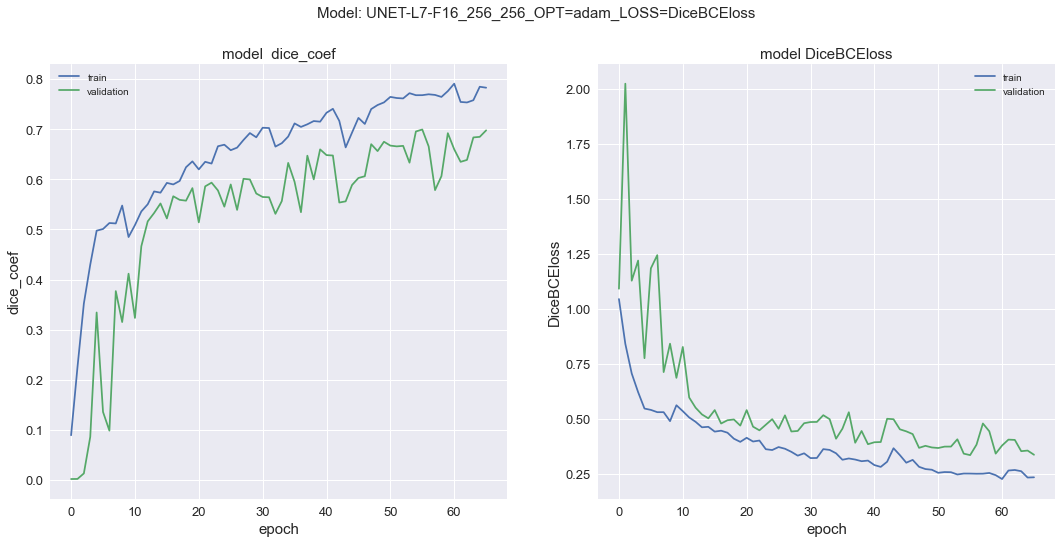

In [14]:
plot_history(model_name, history, metrics, loss, custom_loss=True, custom_metrics=True, figsize=(18,8),labelsize=13, path='../data/plots/' + model_name)

## Predictions

### Training images prediction

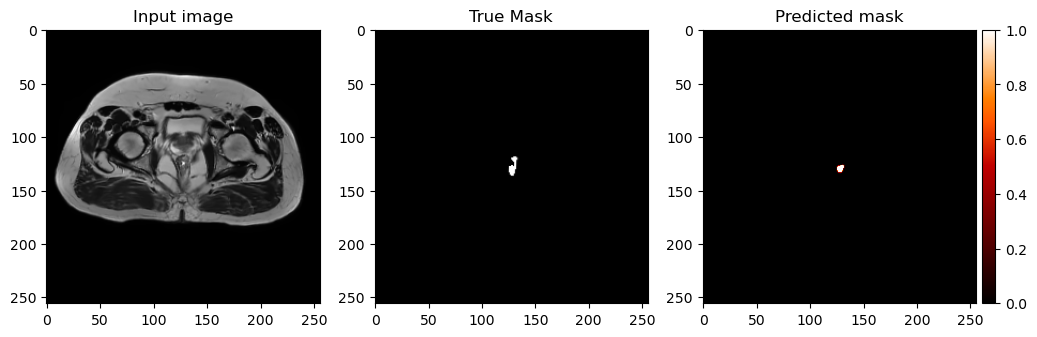

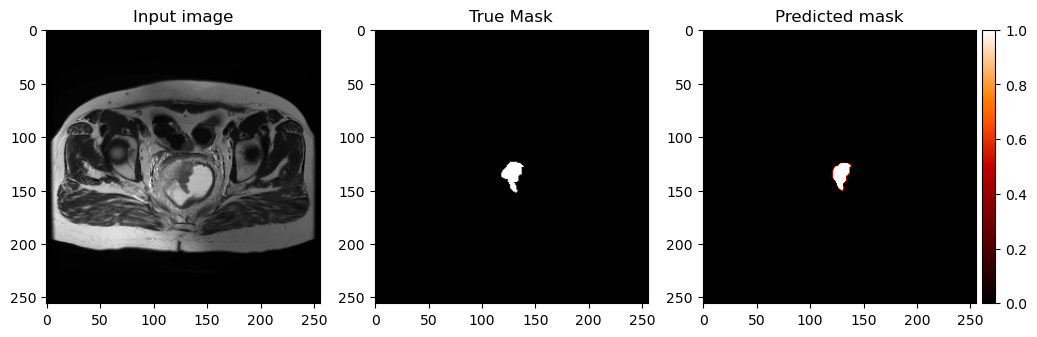

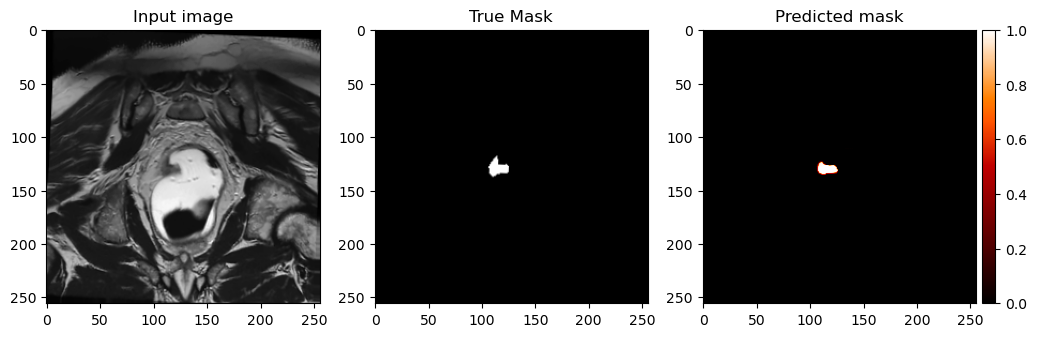

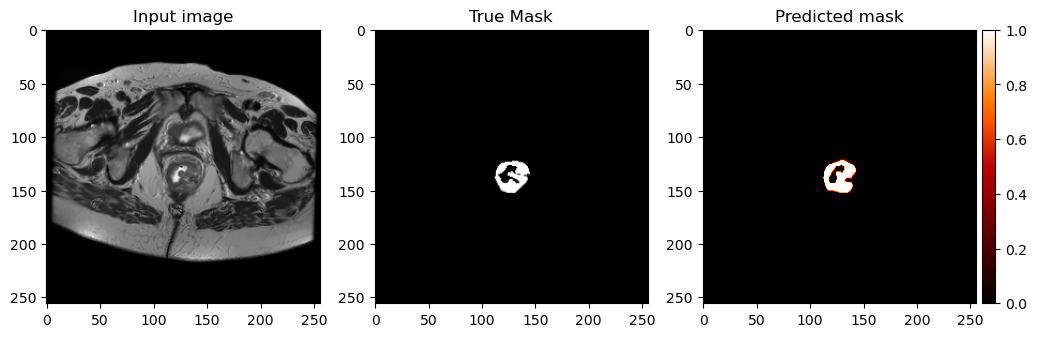

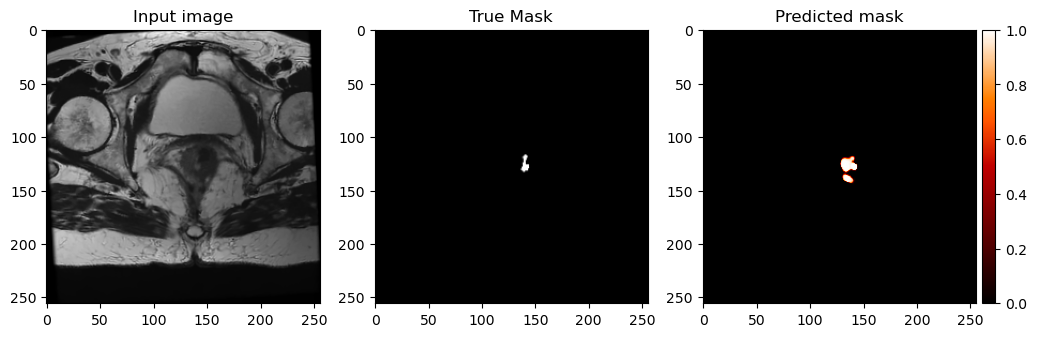

In [15]:
show_prediction(datagen=train_generator, model=model , num=5)

### Validation images prediction

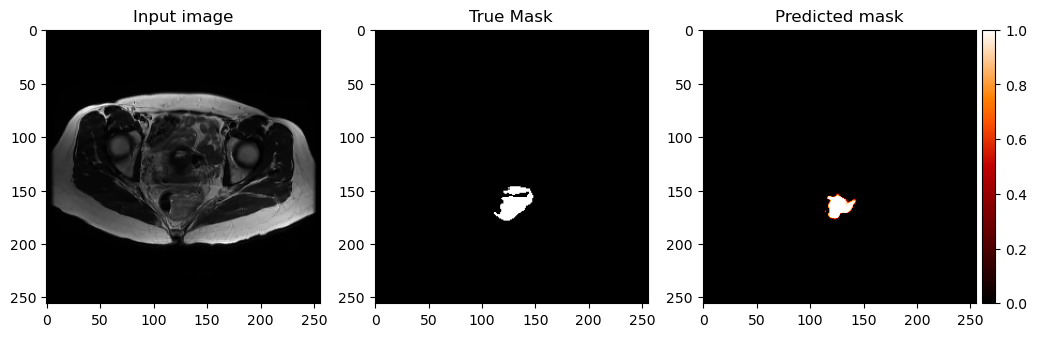

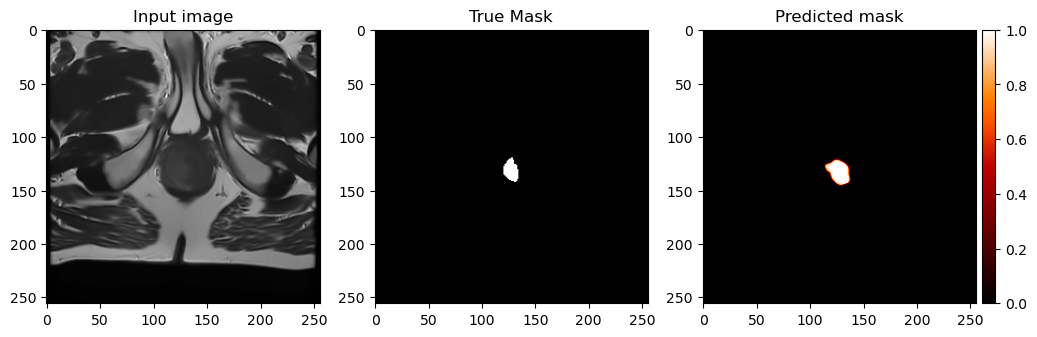

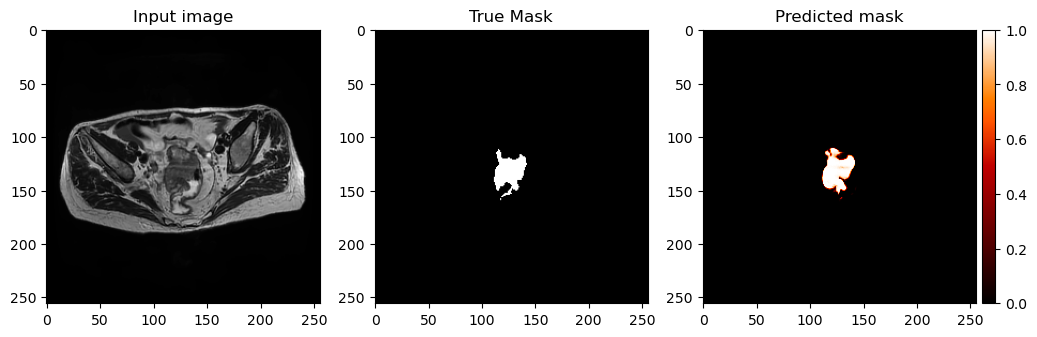

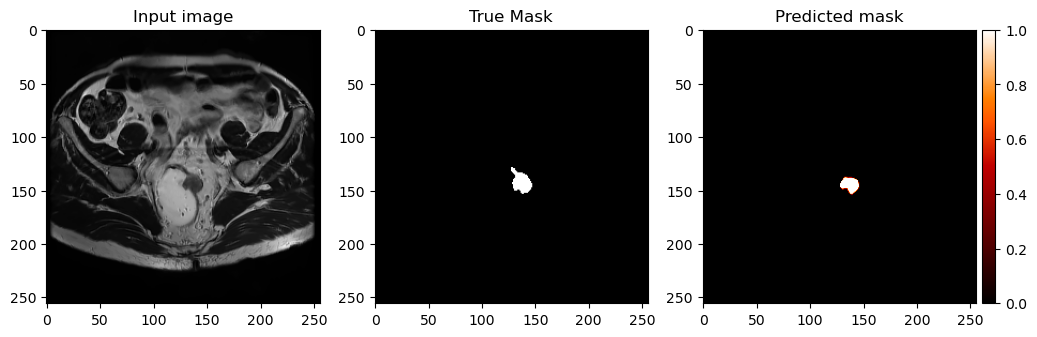

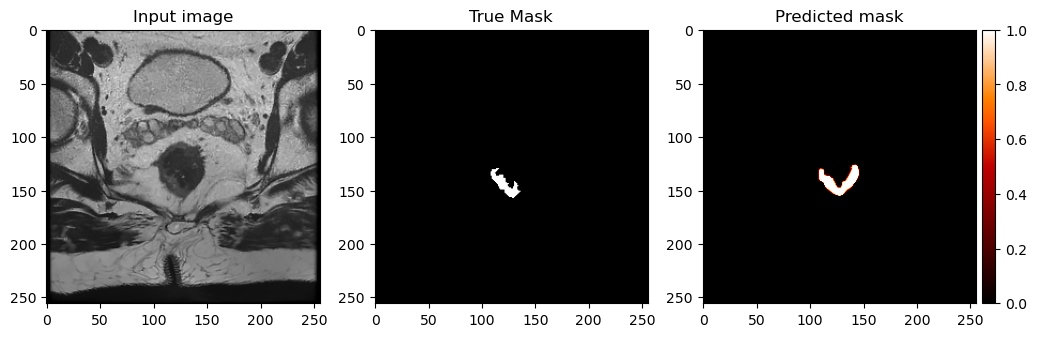

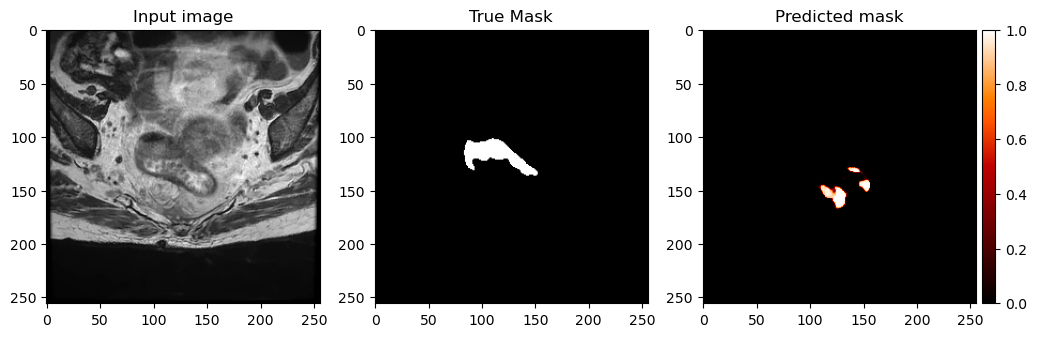

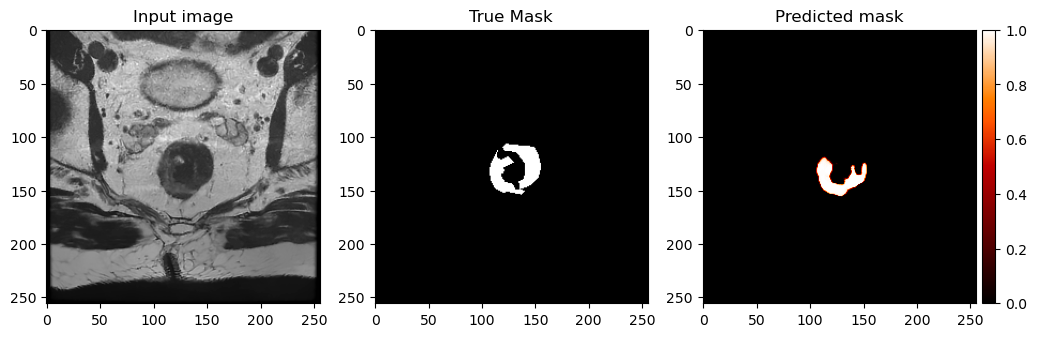

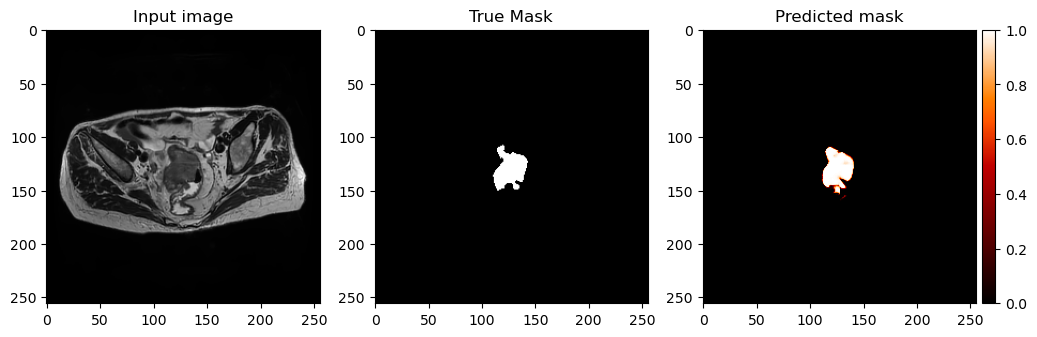

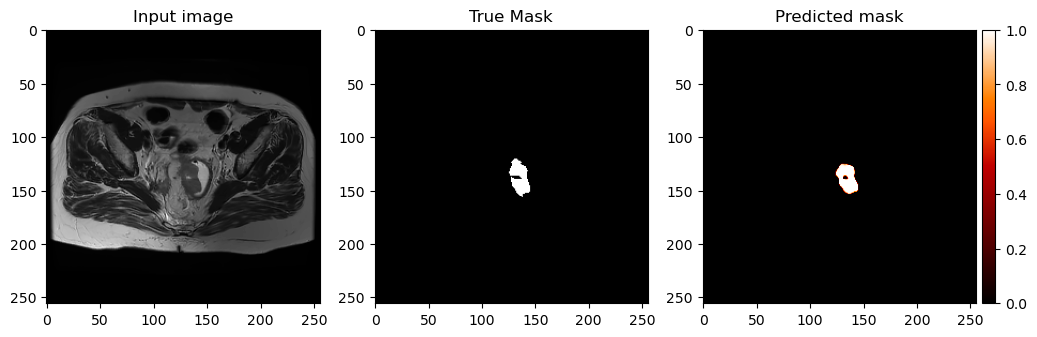

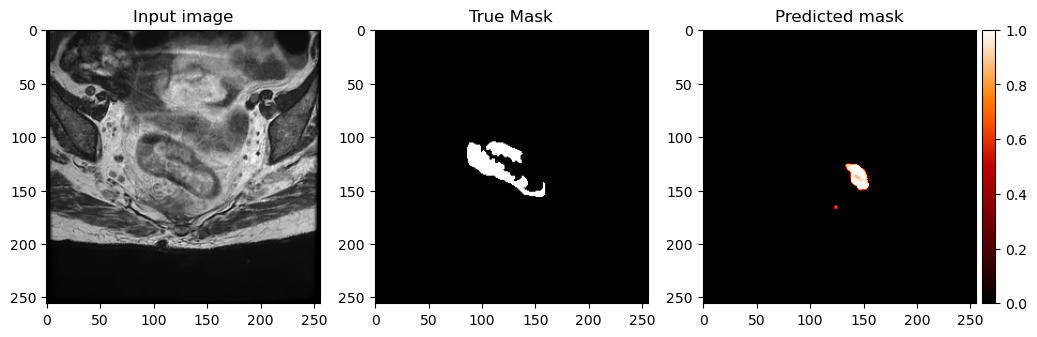

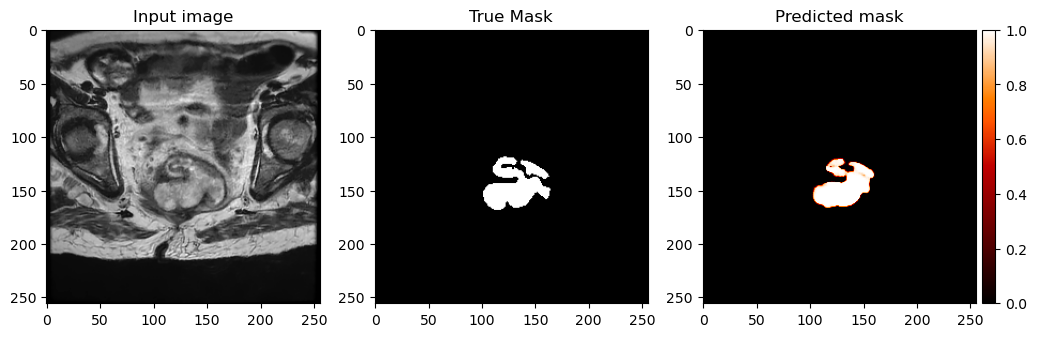

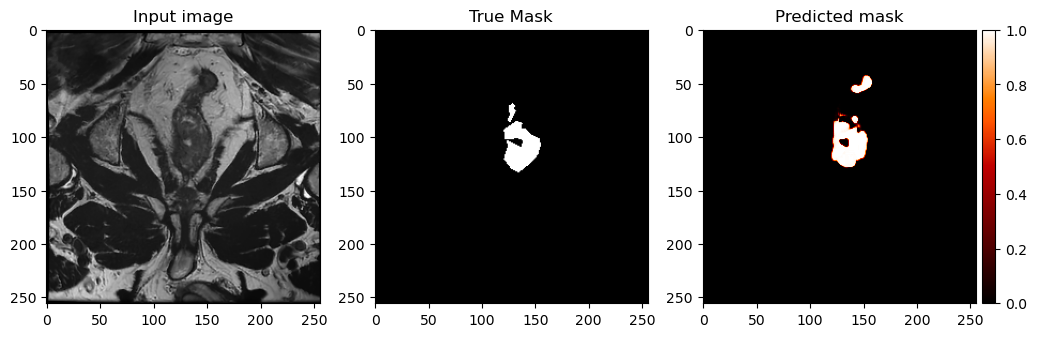

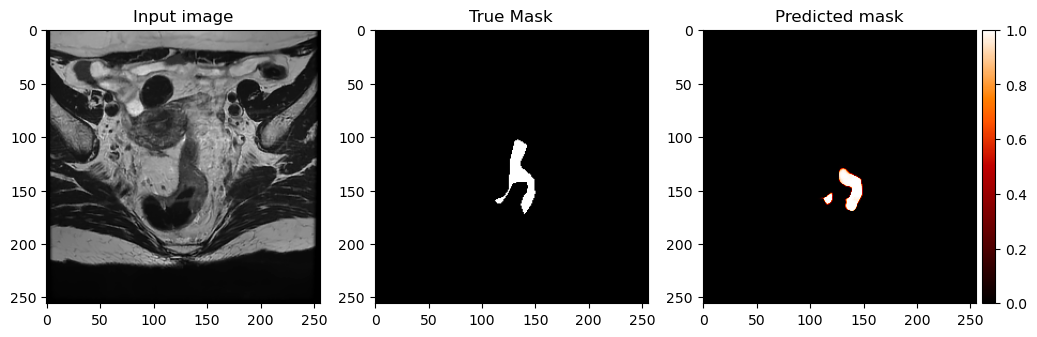

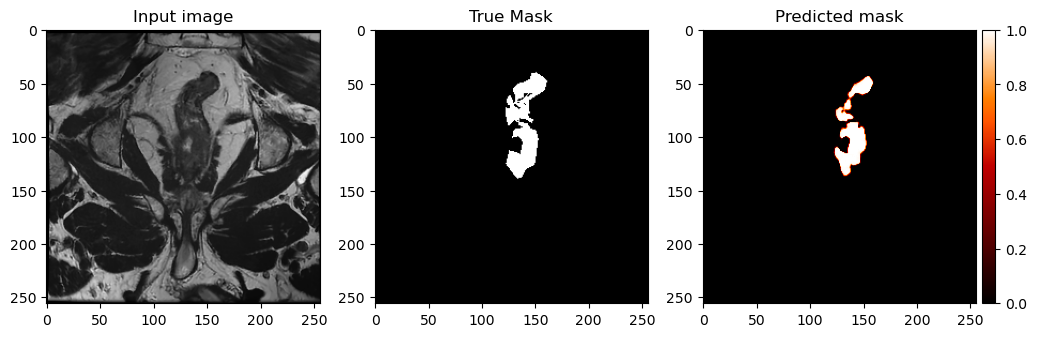

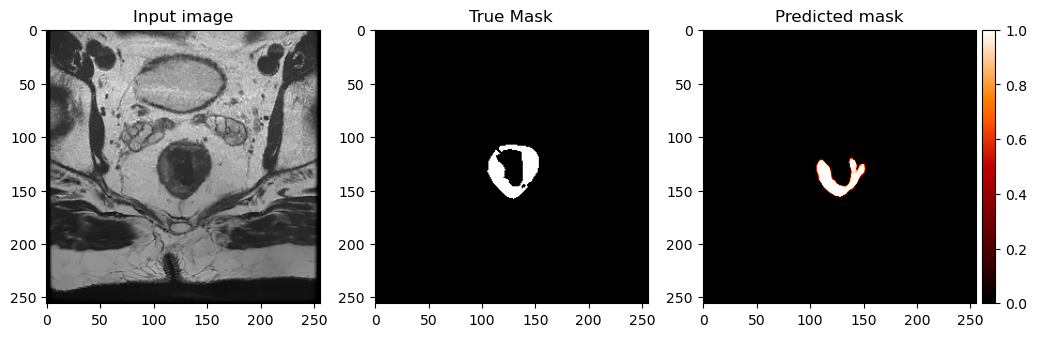

In [17]:
show_prediction(datagen=validation_generator, model=model , num=15)